In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('display.precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Use Celerite v2
import celerite2
from celerite2 import terms

# This script will run from the notebooks/ folder, local imports
# from the ../src folder, data from the ../simulations folder
sys.path.insert(0, os.path.join(os.getcwd(), '../src'))

import clip_windows
import experiment_util
from plot_helpers import *
plotter = PlotUtilCelerite()

## Read the first time series

In [2]:
df = pd.read_csv("../simulations/sim_008_lc.dat",sep=' ', header = None, names=['Time', 'LC', 'N'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
LC      float64
N       float64
dtype: object

In [3]:
X, Y, N = df['Time'].tolist(), df['LC'].tolist(), df['N'].tolist()
X, Y, N = np.array(X), np.array(Y), np.array(N)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

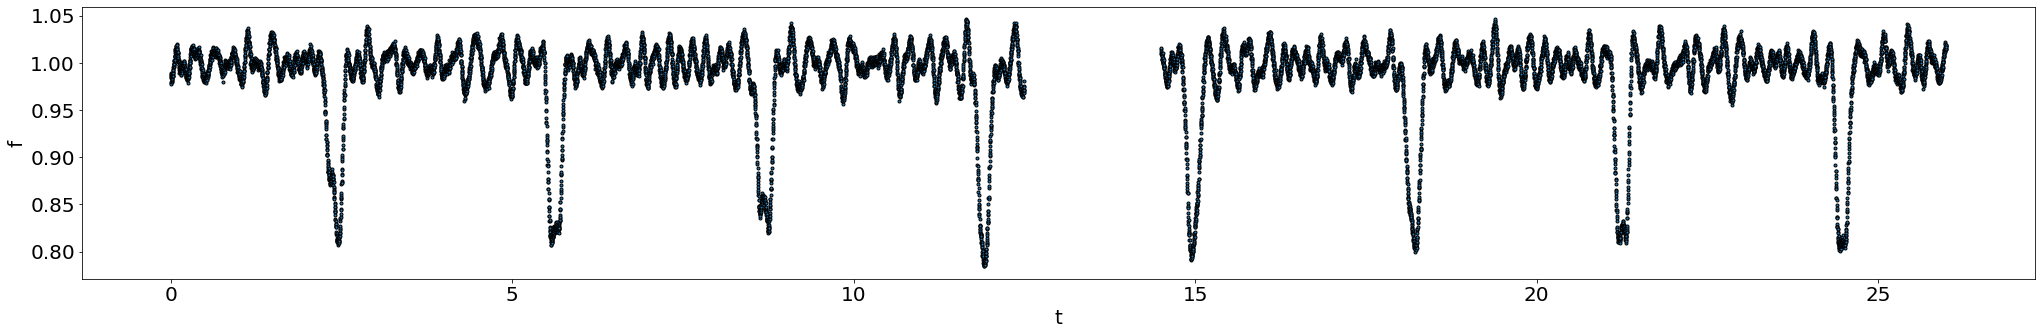

In [4]:
plotter.plot_data(X, Y, fig_width=35, fig_height=5)

array([0.        , 0.31540146, 0.32309418, 0.63849565, 0.63080293])

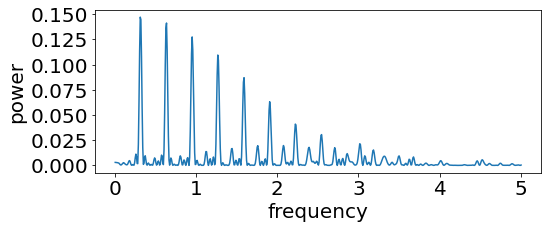

In [5]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [6]:
# For sim_008, 9000 is the first large envelope
N_part=9000

In [7]:
X_part=X[:N_part]
Y_part=Y[:N_part]

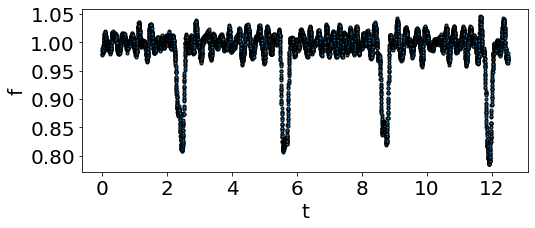

In [8]:
plotter.plot_data(X_part, Y_part)

In [9]:
# Prepare the target grid of evenly-spaced timestamps
sampling_period = experiment_util.median_sampling_period(X_part)
sampling_period

0.001388888888888884

In [10]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.arange(X_part.min(), X_part.max(), sampling_period)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [11]:
sample_period = X[1] - X[0]
first_prim_eclipse_date = X_part[0] + (+3917) * sample_period
first_sec_eclipse_date = X_part[0] + (+1590) * sample_period

# Take the frequency with the highest amplitude from the periodogram!!
eclipse_period = 2 * (1/0.31540146)

window_size = 260  # todo: window size in duration
eclipse_duration = window_size * sample_period
X_part_window, Y_part_window = clip_windows.clip_periodic_windows(X_part, Y_part, eclipse_duration,
                                                     eclipse_period, 
                                                     first_prim_eclipse_date, first_sec_eclipse_date
                                                    )

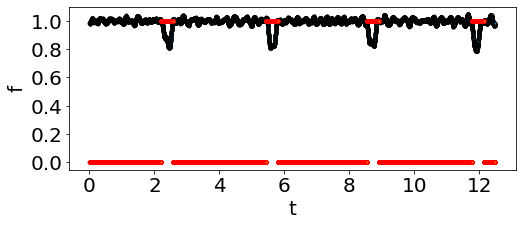

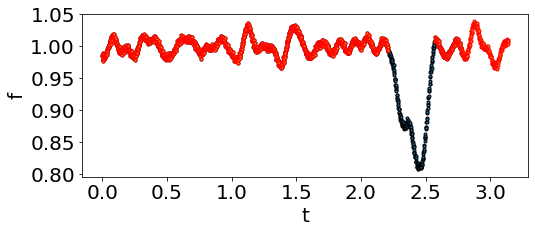

In [12]:
# Plot the masks and the remaining observations after removing the eclipses
X_without_gaps, Y_mask, Y_without_gaps = clip_windows.prepare_masks(X_part, Y_part, X_part_window)

plotter.plot_data(X_part, Y_part, X_part, Y_mask)
plotter.plot_data(X_part[:2000], Y_part[:2000], X_without_gaps[:2000], Y_without_gaps[:2000])
#plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

array([3.05633959, 3.07234137, 3.04033782, 3.64840538, 3.6324036 ])

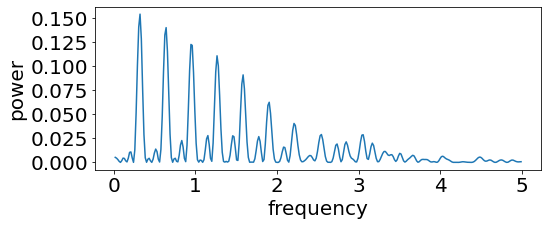

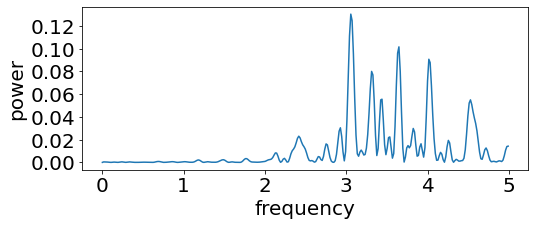

In [13]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

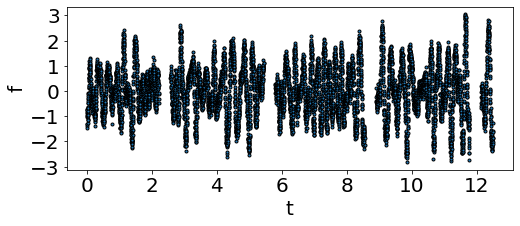

In [14]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal has a major impact on the mean
# In other words, if we normalize first, then remove the E.B., the remaining signal will be somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
# normalize labels
mean, std, Y_part_window = experiment_util.normalize_mean(Y_part_window)
plotter.plot_data(X_part_window, Y_part_window)

# Problem, Y_part and Y_part_window are normalized with different mean and stddev

In [27]:
def set_params(params, gp, kernel_fn, t):
    yerr = 1
    gp.mean = params[0]
    theta = np.exp(params[1:])
    sigma, w0, Q = theta[0:3]
    gp.kernel = kernel_fn([sigma, w0, Q])
    gp.compute(t, diag=yerr ** 2 + theta[3], quiet=True)
    return gp

def neg_log_like(params, gp, kernel_fn, t, y):
    gp = set_params(params, gp, kernel_fn, t)
    return -gp.log_likelihood(y)

In [28]:
def setup_sho_kernel(params):
    sigma, w0, Q = params
    kernel = terms.SHOTerm(sigma=sigma, w0=w0, Q=Q)
    return kernel
    
def setup_model(X):
    # Initialize the Celerite model
    # SHO kernel with the same arguments as for S+Leaf
    sigma=0.04314
    w0=1/3.06242097
    Q=8019.36505
    kernel = setup_sho_kernel([sigma, w0, Q])

    # Setup the GP
    gp = celerite2.GaussianProcess(kernel, mean=0.0)
    gp.compute(X, yerr=0)
    return gp

def train(X: np.ndarray, Y: np.ndarray, gp: celerite2.numpy.GaussianProcess):
    from scipy.optimize import minimize

    # [mean, sigma1, w0_1, Q1, yerr]
    # Q2=0.25
    initial_params = [0.0, 0.04314, 1/3.06242097, np.log(10.0), np.log(0.01)]
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B",
                    args=(gp, setup_sho_kernel, X, Y))
    gp = set_params(soln.x, gp, setup_sho_kernel, X)
    return gp

In [29]:
# Train the model
gp = setup_model(X_part_window)
gp = train(X_part_window, Y_part_window, gp)

In [30]:
# Predict normalized output on the evenly-space grid of timestamps
Y_part_pred_norm, Y_part_pred_var = gp.predict(Y_part_window, t=X_part_smooth, return_var=True)

In [31]:
Y_part_pred = (Y_part_pred_norm * std) + mean

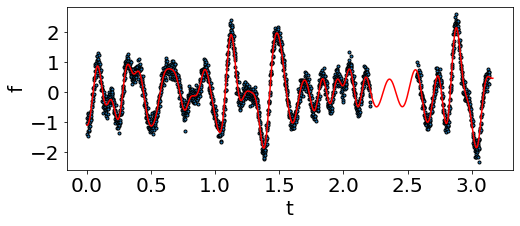

In [32]:
plotter.plot_series(X_part_window[:2000], Y_part_window[:2000], X_part_smooth[:2280], Y_part_pred_norm[:2280])
# plotter.plot_series(X_part_window, Y_part_window, X_part, Y_part_pred_norm)

array([0.        , 3.05633959, 3.07234137, 3.64840538, 4.01644627])

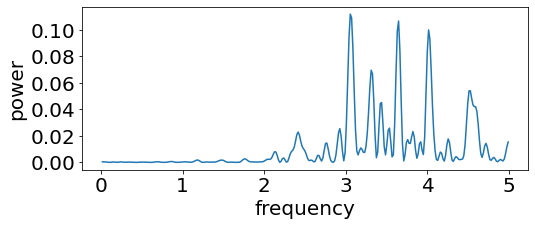

In [33]:
# Find the LS periodogram of the fitted pulsations signal
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part_pred_norm, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [34]:
# All the random noise will end up in the eclipse, we can implement a noise-removal step next
Y_eclipse_part = Y_part - Y_part_pred

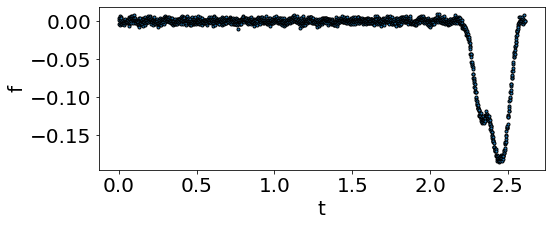

In [35]:
plotter.plot_series(X_part[:1880], Y_eclipse_part[:1880])

array([0.        , 0.32003556, 0.30403378, 0.64007112, 0.62406934])

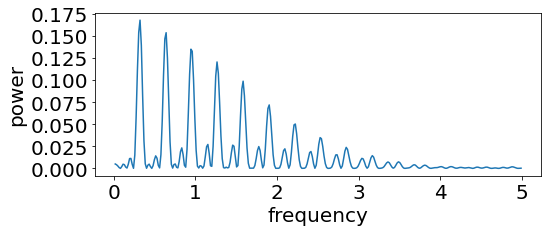

In [43]:
# Find the LS periodogram of the eclipsing binary signal
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_eclipse_part, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]